In [1]:
import pandas as pd
import numpy as np
import time
import datetime
import matplotlib.pyplot as plt
import seaborn as sns
import sqlite3

In [3]:
path_dir = 'C:\\Users\\kumapank\\Documents\\COVID-19\\'

# Data Preprocessing

In [131]:
%%time
conf_df = pd.read_csv(path_dir+'\\input\\time_series_2019 Vertical Data\\time_series-ncov-Confirmed.csv')
conf_df = conf_df.drop(index=0)
dth_df = pd.read_csv(path_dir+'\\input\\time_series_2019 Vertical Data\\time_series-ncov-Deaths.csv')
dth_df = dth_df.drop(index=0)
rcv_df = pd.read_csv(path_dir+'\\input\\time_series_2019 Vertical Data\\time_series-ncov-Recovered.csv')
rcv_df = rcv_df.drop(index=0)

Wall time: 88.2 ms


In [132]:
conf_df.head()

,Province/State,Country/Region,Lat,Long,Date,Value
1,NaN,Afghanistan,33,65,2020-03-18,22
2,NaN,Afghanistan,33,65,2020-03-17,22
3,NaN,Afghanistan,33,65,2020-03-16,21
4,NaN,Afghanistan,33,65,2020-03-15,16
5,NaN,Afghanistan,33,65,2020-03-14,11


In [133]:
conf_df.Date = pd.to_datetime(conf_df.Date, format='%Y-%m-%d')
dth_df.Date = pd.to_datetime(dth_df.Date, format='%Y-%m-%d')
rcv_df.Date = pd.to_datetime(rcv_df.Date, format='%Y-%m-%d')

In [134]:
print(f"confirm data size= {conf_df.shape}, deth data size= {dth_df.shape}, recover data size= {rcv_df.shape}")

confirm data size= (26334, 6), deth data size= (26334, 6), recover data size= (26334, 6)


In [135]:
agg_df = pd.merge(conf_df,dth_df,left_on=['Province/State','Country/Region','Lat','Long','Date'],right_on=['Province/State','Country/Region','Lat','Long','Date'],how='left')
agg_df.columns = ['Province/State','Country/Region','Lat','Long','Date','Confirmed','Death']
agg_df = pd.merge(agg_df,rcv_df,left_on=['Province/State','Country/Region','Lat','Long','Date'],right_on=['Province/State','Country/Region','Lat','Long','Date'],how='left')
agg_df.columns = ['Province/State','Country/Region','Lat','Long','Date','Confirmed','Death','Recovered']

In [74]:
agg_df.head()

,Province/State,Country/Region,Lat,Long,Date,Confirmed,Death,Recovered
0,NaN,Afghanistan,33,65,2020-03-17,22,0,1
1,NaN,Afghanistan,33,65,2020-03-16,21,0,1
2,NaN,Afghanistan,33,65,2020-03-15,16,0,0
3,NaN,Afghanistan,33,65,2020-03-14,11,0,0
4,NaN,Afghanistan,33,65,2020-03-13,7,0,0


In [136]:
agg_df = agg_df.sort_values(by=['Province/State','Country/Region','Date'],ascending=[True,True,False])
agg_df['New_case']= agg_df.Confirmed.astype('float').diff(periods=-1)
agg_df.loc[agg_df.Date =='2020-01-22','New_case'] = 0

In [137]:
agg_df.head()

,Province/State,Country/Region,Lat,Long,Date,Confirmed,Death,Recovered,New_case
12027,"Adams, IN",US,39.8522,-77.2865,2020-03-18,0,0,0,0.0
12028,"Adams, IN",US,39.8522,-77.2865,2020-03-17,0,0,0,0.0
12029,"Adams, IN",US,39.8522,-77.2865,2020-03-16,0,0,0,0.0
12030,"Adams, IN",US,39.8522,-77.2865,2020-03-15,0,0,0,0.0
12031,"Adams, IN",US,39.8522,-77.2865,2020-03-14,0,0,0,0.0


# Growth Factor

In [138]:
%%time
agg_df['Growth_Factor'] = agg_df.New_case.rolling(window=2).apply(lambda x: x.iloc[0]/x.iloc[1]).replace([np.nan,np.inf],0)
# agg_df.loc[agg_df.Date =='2020-03-17','Growth_Factor'] = None
agg_df.head()

Wall time: 1.69 s


,Province/State,Country/Region,Lat,Long,Date,Confirmed,Death,Recovered,New_case,Growth_Factor
12027,"Adams, IN",US,39.8522,-77.2865,2020-03-18,0,0,0,0.0,0.0
12028,"Adams, IN",US,39.8522,-77.2865,2020-03-17,0,0,0,0.0,0.0
12029,"Adams, IN",US,39.8522,-77.2865,2020-03-16,0,0,0,0.0,0.0
12030,"Adams, IN",US,39.8522,-77.2865,2020-03-15,0,0,0,0.0,0.0
12031,"Adams, IN",US,39.8522,-77.2865,2020-03-14,0,0,0,0.0,0.0


In [286]:
def plot_country_growth_factor(Country):
    temp = agg_df[agg_df['Country/Region'] == Country]
    temp = pd.DataFrame(temp.groupby(by=['Country/Region','Date']).New_case.sum()).reset_index()
    temp = temp.sort_values(by=['Date'],ascending=False)
    temp['Growth_Factor'] = temp.New_case.rolling(window=2).apply(lambda x: x.iloc[0]/x.iloc[1]).replace([np.nan,np.inf],0)
    temp.loc[temp.Date =='2020-03-18','Growth_Factor'] = None
    sns.set(style="darkgrid")
    plt.figure(figsize=(12,5))
    ax = sns.lineplot(x="Date", y="Growth_Factor", lw=1,data=temp)
    ax.axhline(1)
    return

# COVID19: Growth Factor 
## India

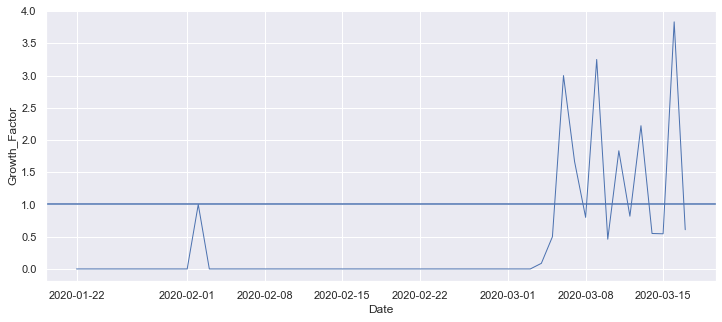

In [287]:
plot_country_growth_factor('India')

## China 

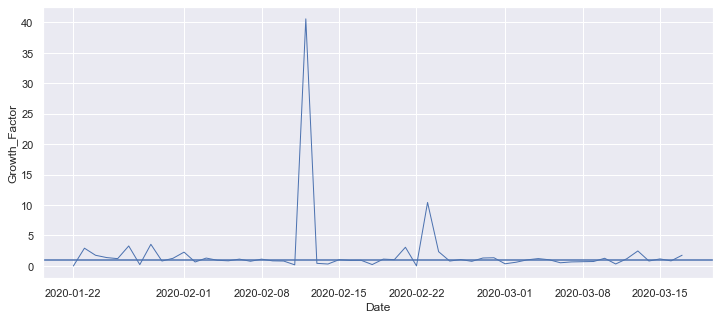

In [141]:
plot_country_growth_factor('China')

## USA 

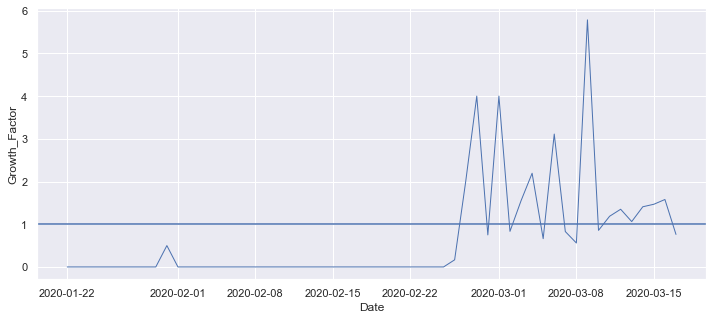

In [142]:
plot_country_growth_factor('US')

## Italy

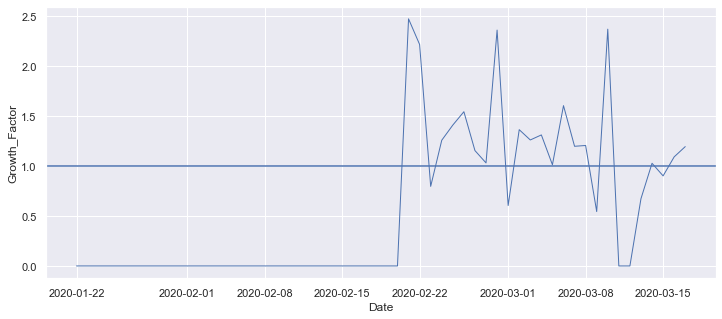

In [143]:
plot_country_growth_factor('Italy')

# COVID19 Testing Globally

In [243]:
testing_df = pd.read_csv(path_dir+'\\input\\covid-19-tests-country.csv')
testing_df.head()

,Entity,Code,Year,Total COVID-19 tests
0,Armenia,ARM,55,694
1,Australia - Government of the Australian Capit...,AUS,56,1391
2,Australia - New South Wales,AUS,56,30244
3,Austria,AUT,56,10278
4,Bahrain,BHR,56,13553


In [249]:
testing_df = pd.DataFrame(testing_df.groupby(by=['Code'])['Total COVID-19 tests'].sum()).reset_index()
testing_df.head()

,Code,Total COVID-19 tests
0,ARE,125000
1,ARM,694
2,AUS,31635
3,AUT,10278
4,BEL,4225


In [251]:
# agg_df = pd.merge(agg_df,testing_df,left_on='Country Code',right_on='Code',how='left')
# agg_df.head()

# Adding Population Density

Recoded Per square KM

In [144]:
filename = path_dir+'\\input\\API_EN.POP.DNST_DS2_en_csv_v2_868885\\API_EN.POP.DNST_DS2_en_csv_v2_868885.csv'
pop_dst = pd.read_csv(filename,skiprows=3)
pop_dst.shape

(264, 65)

In [145]:
density_col = ['Country Name','Country Code','2014','2015','2016','2017','2018']
pop_dst = pop_dst[density_col]
density_col = ['Country Name','Country Code','density_2014','density_2015','density_2016','density_2017','density_2018']
pop_dst.columns = density_col
del(density_col)
pop_dst.head()

,Country Name,Country Code,density_2014,density_2015,density_2016,density_2017,density_2018
0,Aruba,ABW,576.522222,579.672222,582.622222,585.366667,588.027778
1,Afghanistan,AFG,51.114778,52.712072,54.197114,55.595993,56.937760
2,Angola,AGO,21.610475,22.366552,23.135064,23.916538,24.713052
3,Albania,ALB,105.441752,105.135146,104.967190,104.870693,104.612263
4,Andorra,AND,168.538298,165.980851,164.461702,163.831915,163.842553


In [54]:
country_code=pd.read_csv(path_dir+'input\\Country_Code_V1.csv')

In [146]:
agg_df = pd.merge(agg_df,country_code,left_on='Country/Region',right_on='Country/Region',how='left')
agg_df = pd.merge(agg_df,pop_dst[['Country Code','density_2018']],left_on='Country Code',right_on='Country Code',how='left')
agg_df.head()

,Province/State,Country/Region,Lat,Long,Date,Confirmed,Death,Recovered,New_case,Growth_Factor,Country Code,density_2018
0,"Adams, IN",US,39.8522,-77.2865,2020-03-18,0,0,0,0.0,0.0,USA,35.766089
1,"Adams, IN",US,39.8522,-77.2865,2020-03-17,0,0,0,0.0,0.0,USA,35.766089
2,"Adams, IN",US,39.8522,-77.2865,2020-03-16,0,0,0,0.0,0.0,USA,35.766089
3,"Adams, IN",US,39.8522,-77.2865,2020-03-15,0,0,0,0.0,0.0,USA,35.766089
4,"Adams, IN",US,39.8522,-77.2865,2020-03-14,0,0,0,0.0,0.0,USA,35.766089


# Adding Demography
Demography: Population Age 15-64 (% of Total Population)

In [147]:
filename = path_dir+'\\input\\API_SP.POP.1564.TO.ZS_DS2_en_csv_v2_867025\\API_SP.POP.1564.TO.ZS_DS2_en_csv_v2_867025.csv'
demo_df = pd.read_csv(filename,skiprows=3)
demo_df.shape

(264, 65)

In [148]:
density_col = ['Country Name','Country Code','2018']
demo_df = demo_df[density_col]
demo_col = ['Country Name','Country Code','Demography_2018']
demo_df.columns = demo_col
del(density_col,demo_col)
demo_df.head()

,Country Name,Country Code,Demography_2018
0,Aruba,ABW,68.646606
1,Afghanistan,AFG,54.324898
2,Angola,AGO,50.974702
3,Albania,ALB,68.582390
4,Andorra,AND,NaN


In [149]:
agg_df = pd.merge(agg_df,demo_df[['Country Code','Demography_2018']],left_on='Country Code',right_on='Country Code',how='left')
agg_df.head()

,Province/State,Country/Region,Lat,Long,Date,Confirmed,Death,Recovered,New_case,Growth_Factor,Country Code,density_2018,Demography_2018
0,"Adams, IN",US,39.8522,-77.2865,2020-03-18,0,0,0,0.0,0.0,USA,35.766089,65.483306
1,"Adams, IN",US,39.8522,-77.2865,2020-03-17,0,0,0,0.0,0.0,USA,35.766089,65.483306
2,"Adams, IN",US,39.8522,-77.2865,2020-03-16,0,0,0,0.0,0.0,USA,35.766089,65.483306
3,"Adams, IN",US,39.8522,-77.2865,2020-03-15,0,0,0,0.0,0.0,USA,35.766089,65.483306
4,"Adams, IN",US,39.8522,-77.2865,2020-03-14,0,0,0,0.0,0.0,USA,35.766089,65.483306


# Adding Physicians (per 1,000 people)
Data is available from 1960 but not populated all the years. We have taken the average of all the years starting 1960 to 2018. Keeping in mind that population is increasing over period of time so ratio is being adjusted.

In [150]:
filename = path_dir+'\\input\\API_SH.MED.PHYS.ZS_DS2_en_csv_v2_868622\\API_SH.MED.PHYS.ZS_DS2_en_csv_v2_868622.csv'
phy_df = pd.read_csv(filename,skiprows=3)
phy_df.shape

(264, 65)

In [151]:
phy_df.head()

,Country Name,Country Code,Indicator Name,Indicator Code,1960,1961,1962,1963,1964,1965,...,2011,2012,2013,2014,2015,2016,2017,2018,2019,Unnamed: 64
0,Aruba,ABW,"Physicians (per 1,000 people)",SH.MED.PHYS.ZS,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,Afghanistan,AFG,"Physicians (per 1,000 people)",SH.MED.PHYS.ZS,0.035,NaN,NaN,NaN,NaN,0.063,...,0.2553,0.2450,0.2894,0.3039,0.2907,0.2840,NaN,NaN,NaN,NaN
2,Angola,AGO,"Physicians (per 1,000 people)",SH.MED.PHYS.ZS,0.067,NaN,NaN,NaN,NaN,0.076,...,NaN,NaN,NaN,NaN,NaN,NaN,0.2149,NaN,NaN,NaN
3,Albania,ALB,"Physicians (per 1,000 people)",SH.MED.PHYS.ZS,0.276,NaN,NaN,NaN,NaN,0.481,...,1.2225,1.2658,1.2706,NaN,NaN,1.1998,NaN,NaN,NaN,NaN
4,Andorra,AND,"Physicians (per 1,000 people)",SH.MED.PHYS.ZS,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,3.3333,NaN,NaN,NaN,NaN,NaN


In [152]:
avg_phy_ratio_2018 = phy_df.iloc[:,4:63].mean(axis=1)
phy_col = ['Country Name','Country Code']
phy_df = phy_df[phy_col]
phy_df['DrRatio'] = avg_phy_ratio_2018.copy()
del(phy_col)
phy_df.head()

,Country Name,Country Code,DrRatio
0,Aruba,ABW,1.120000
1,Afghanistan,AFG,0.178623
2,Angola,AGO,0.091800
3,Albania,ALB,1.203848
4,Andorra,AND,3.000633


In [153]:
agg_df = pd.merge(agg_df,phy_df[['Country Code','DrRatio']],left_on='Country Code',right_on='Country Code',how='left')
agg_df.head()

,Province/State,Country/Region,Lat,Long,Date,Confirmed,Death,Recovered,New_case,Growth_Factor,Country Code,density_2018,Demography_2018,DrRatio
0,"Adams, IN",US,39.8522,-77.2865,2020-03-18,0,0,0,0.0,0.0,USA,35.766089,65.483306,1.999229
1,"Adams, IN",US,39.8522,-77.2865,2020-03-17,0,0,0,0.0,0.0,USA,35.766089,65.483306,1.999229
2,"Adams, IN",US,39.8522,-77.2865,2020-03-16,0,0,0,0.0,0.0,USA,35.766089,65.483306,1.999229
3,"Adams, IN",US,39.8522,-77.2865,2020-03-15,0,0,0,0.0,0.0,USA,35.766089,65.483306,1.999229
4,"Adams, IN",US,39.8522,-77.2865,2020-03-14,0,0,0,0.0,0.0,USA,35.766089,65.483306,1.999229


# Hospital Bed per 1000 People
Data is available from 1960 but not populated all the years. We have taken the average of all the years starting 1960 to 2018.

In [154]:
filename = path_dir+'\\input\\API_SH.MED.BEDS.ZS_DS2_en_csv_v2_867087\\API_SH.MED.BEDS.ZS_DS2_en_csv_v2_867087.csv'
bed_df = pd.read_csv(filename,skiprows=3)
bed_df.shape

(264, 65)

In [155]:
bed_df.head()

,Country Name,Country Code,Indicator Name,Indicator Code,1960,1961,1962,1963,1964,1965,...,2011,2012,2013,2014,2015,2016,2017,2018,2019,Unnamed: 64
0,Aruba,ABW,"Hospital beds (per 1,000 people)",SH.MED.BEDS.ZS,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,Afghanistan,AFG,"Hospital beds (per 1,000 people)",SH.MED.BEDS.ZS,0.170627,NaN,NaN,NaN,NaN,NaN,...,0.4,0.5,0.5,0.5,0.5,NaN,NaN,NaN,NaN,NaN
2,Angola,AGO,"Hospital beds (per 1,000 people)",SH.MED.BEDS.ZS,2.061462,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,Albania,ALB,"Hospital beds (per 1,000 people)",SH.MED.BEDS.ZS,5.102676,NaN,NaN,NaN,NaN,NaN,...,2.6,2.9,2.9,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,Andorra,AND,"Hospital beds (per 1,000 people)",SH.MED.BEDS.ZS,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [156]:
avg_bed_2018 = bed_df.iloc[:,4:63].mean(axis=1)
bed_col = ['Country Name','Country Code']
bed_df = bed_df[bed_col]
bed_df['PatientBed'] = avg_bed_2018.copy()
del(bed_col)
bed_df.head()

,Country Name,Country Code,PatientBed
0,Aruba,ABW,NaN
1,Afghanistan,AFG,0.376387
2,Angola,AGO,1.718440
3,Albania,ALB,3.524676
4,Andorra,AND,2.905455


In [157]:
agg_df = pd.merge(agg_df,bed_df[['Country Code','PatientBed']],left_on='Country Code',right_on='Country Code',how='left')
agg_df.head()

,Province/State,Country/Region,Lat,Long,Date,Confirmed,Death,Recovered,New_case,Growth_Factor,Country Code,density_2018,Demography_2018,DrRatio,PatientBed
0,"Adams, IN",US,39.8522,-77.2865,2020-03-18,0,0,0,0.0,0.0,USA,35.766089,65.483306,1.999229,5.02
1,"Adams, IN",US,39.8522,-77.2865,2020-03-17,0,0,0,0.0,0.0,USA,35.766089,65.483306,1.999229,5.02
2,"Adams, IN",US,39.8522,-77.2865,2020-03-16,0,0,0,0.0,0.0,USA,35.766089,65.483306,1.999229,5.02
3,"Adams, IN",US,39.8522,-77.2865,2020-03-15,0,0,0,0.0,0.0,USA,35.766089,65.483306,1.999229,5.02
4,"Adams, IN",US,39.8522,-77.2865,2020-03-14,0,0,0,0.0,0.0,USA,35.766089,65.483306,1.999229,5.02


In [158]:
agg_df.to_csv(path_dir+'\\output\\Covid19_master_dataV1.csv',index=False)

,Province/State,Country/Region,Lat,Long,Date,Confirmed,Death,Recovered,New_case,Growth_Factor,Country Code,density_2018,Demography_2018,DrRatio,PatientBed
21489,NaN,India,21,78,2020-03-18,156,3,14,14.0,0.000000,IND,454.938073,66.766742,0.5428,0.721266
21490,NaN,India,21,78,2020-03-17,142,3,14,23.0,0.608696,IND,454.938073,66.766742,0.5428,0.721266
21491,NaN,India,21,78,2020-03-16,119,2,13,6.0,3.833333,IND,454.938073,66.766742,0.5428,0.721266
21492,NaN,India,21,78,2020-03-15,113,2,13,11.0,0.545455,IND,454.938073,66.766742,0.5428,0.721266
21493,NaN,India,21,78,2020-03-14,102,2,4,20.0,0.550000,IND,454.938073,66.766742,0.5428,0.721266


# Tweeter Data

In [236]:
sqlfile = path_dir+'\\input\\corona_tweets_2L\\tweets.db'

In [237]:
conn = sqlite3.connect(sqlfile)
cur = conn.cursor()
cur.execute("select * from sentiment")

In [238]:
tweets_df = pd.DataFrame(cur.fetchall())
tweets_df.columns=['UnixID','tweets','sentiments']
conn.close()
tweets_df.head()

,UnixID,tweets,sentiments
0,1.584415e+12,RT @saintIournt: if corona has ruined somethin...,0.000000
1,1.584415e+12,RT @jh_803: Stop taking Corona lightly/as a jo...,-0.163889
2,1.584415e+12,@_WeThePeople1st Get full protection against c...,0.350000
3,1.584415e+12,RT @ottolenghi: 'A love letter home' - recipes...,0.400000
4,1.584415e+12,@ShannonSharpe You only believe the negativity...,-0.100000


In [239]:
tweets_df['Date'] = pd.to_datetime(tweets_df.UnixID.astype('int64'), unit='ms',origin='unix')
tweets_df.head()

,UnixID,tweets,sentiments,Date
0,1.584415e+12,RT @saintIournt: if corona has ruined somethin...,0.000000,2020-03-17 03:12:25.136
1,1.584415e+12,RT @jh_803: Stop taking Corona lightly/as a jo...,-0.163889,2020-03-17 03:12:25.159
2,1.584415e+12,@_WeThePeople1st Get full protection against c...,0.350000,2020-03-17 03:12:25.167
3,1.584415e+12,RT @ottolenghi: 'A love letter home' - recipes...,0.400000,2020-03-17 03:12:25.178
4,1.584415e+12,@ShannonSharpe You only believe the negativity...,-0.100000,2020-03-17 03:12:25.252


In [240]:
tweets_df.tweets[2]

'@_WeThePeople1st Get full protection against corona virus now: https://t.co/96fjH5EVVh'

In [241]:
tweets_df.to_csv(path_dir+'\\output\\Tweeter_2L.csv')

# Probability Distribution Fitting

In [342]:
temp = agg_df[agg_df['Country/Region']=='Italy']
temp=temp[['Date','Confirmed','New_case']].set_index('Date')
temp = temp.sort_index()
temp = temp.reset_index(drop = True)
temp = temp.drop([0])
temp.head()

,Confirmed,New_case
1,0,0.0
2,0,0.0
3,0,0.0
4,0,0.0
5,0,0.0


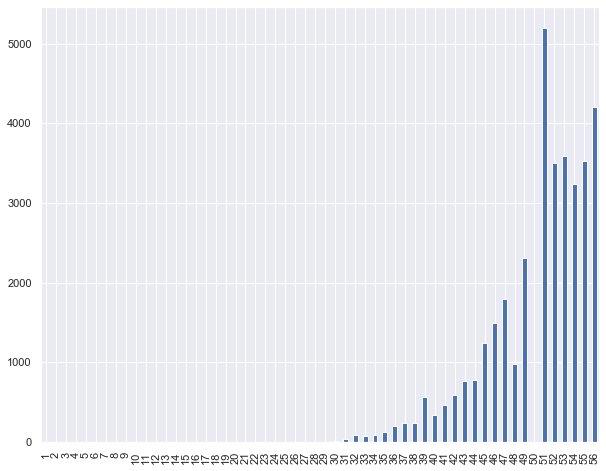

In [343]:
# fig, ax = plt.subplots(1, 1)
plt.figure(figsize=(10,8))
ax = temp.New_case.plot(kind='bar')
# 
# ax.hist(temp.New_case, density=True, histtype='stepfilled', alpha=0.2)
# # ax.legend(loc='best', frameon=False)
# plt.show()

In [344]:
x = np.array(temp.New_case)
y = np.array(temp.index)

In [350]:
scipy.optimize.curve_fit(lambda t,a,b: a*np.exp(b*t),  x,  y,p0=(0.5, 0.1))

c:\users\kumapank\appdata\local\programs\python\python38\lib\site-packages\scipy\optimize\minpack.py:766: RuntimeWarning: overflow encountered in square
  cost = np.sum(infodict['fvec'] ** 2)
c:\users\kumapank\appdata\local\programs\python\python38\lib\site-packages\scipy\optimize\minpack.py:807: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',


(array([-3.55011625e-17,  1.00000000e-01]),
 array([[inf, inf],
        [inf, inf]]))

In [ ]:
>>> x = numpy.array([10, 19, 30, 35, 51])
>>> y = numpy.array([1, 7, 20, 50, 79])
>>> scipy.optimize.curve_fit(lambda t,a,b: a*numpy.exp(b*t),  x,  y)
(array([  5.60728326e-21,   9.99993501e-01]),
 array([[  4.14809412e-27,  -1.45078961e-08],
        [ -1.45078961e-08,   5.07411462e+10]]))
# oops, definitely wrong.
>>> scipy.optimize.curve_fit(lambda t,a,b: a*numpy.exp(b*t),  x,  y,  p0=(4, 0.1))
(array([ 4.88003249,  0.05531256]),
 array([[  1.01261314e+01,  -4.31940132e-02],
        [ -4.31940132e-02,   1.91188656e-04]]))

In [311]:
import scipy.stats as st
%matplotlib inline

In [320]:
smean = temp.New_case.mean()
rate = 1. / smean
smean

626.5438596491229

In [321]:
smax = temp.New_case.max()
days = np.linspace(0., smax, 1000)
# bin size: interval between two
# consecutive values in `days`
dt = smax / 999.
smax

5198.0

(array([42.,  5.,  2.,  1.,  1.,  0.,  4.,  0.,  1.,  1.]),
 array([   0. ,  519.8, 1039.6, 1559.4, 2079.2, 2599. , 3118.8, 3638.6,
        4158.4, 4678.2, 5198. ]),
 <a list of 10 Patch objects>)

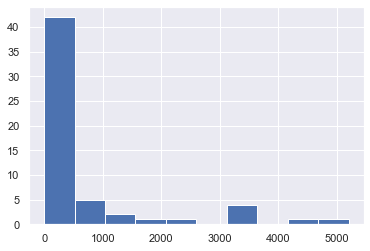

In [327]:
nbins = 90
fig, ax = plt.subplots(1, 1, figsize=(6, 4))
ax.hist(temp.New_case)

In [317]:
dist_exp = st.expon.pdf(days, scale=1. / rate)

Text(0, 0.5, 'Number of Confirmed Case')

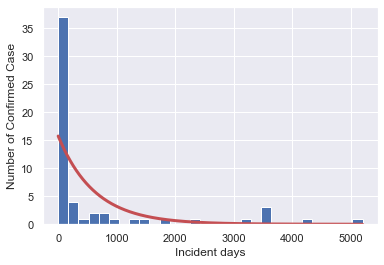

In [318]:
nbins = 30
fig, ax = plt.subplots(1, 1, figsize=(6, 4))
ax.hist(temp.New_case, nbins)
ax.plot(days, dist_exp * len(temp.New_case) * smax / nbins,
        '-r', lw=3)
ax.set_xlabel("Incident days")
ax.set_ylabel("Number of Confirmed Case")

<ipython-input-257-b5a098dc9a47>:5: DeprecationWarning: scipy.arange is deprecated and will be removed in SciPy 2.0.0, use numpy.arange instead
  x = scipy.arange(size)
<ipython-input-257-b5a098dc9a47>:6: DeprecationWarning: scipy.round_ is deprecated and will be removed in SciPy 2.0.0, use numpy.round_ instead
  y = scipy.int_(scipy.round_(scipy.stats.vonmises.rvs(5,size=size)*47))
c:\users\kumapank\appdata\local\programs\python\python38\lib\site-packages\scipy\stats\_continuous_distns.py:547: RuntimeWarning: invalid value encountered in sqrt
  sk = 2*(b-a)*np.sqrt(a + b + 1) / (a + b + 2) / np.sqrt(a*b)
c:\users\kumapank\appdata\local\programs\python\python38\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
c:\users\kumapank\appdata\local\programs\python\python38\lib\site-packages\scipy\stats\_distn_infrastructure.py:2407: Run

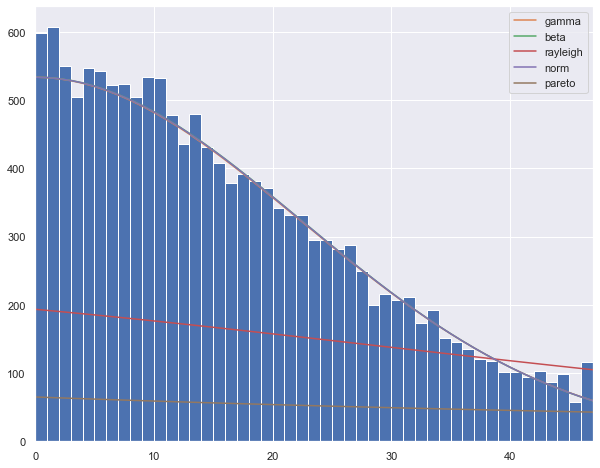

In [257]:
import matplotlib.pyplot as plt
import scipy
import scipy.stats
size = 30000
x = scipy.arange(size)
y = scipy.int_(scipy.round_(scipy.stats.vonmises.rvs(5,size=size)*47))
plt.figure(figsize=(10,8))
h = plt.hist(y, bins=range(48))

dist_names = ['gamma', 'beta', 'rayleigh', 'norm', 'pareto']

for dist_name in dist_names:
    dist = getattr(scipy.stats, dist_name)
    param = dist.fit(y)
    pdf_fitted = dist.pdf(x, *param[:-2], loc=param[-2], scale=param[-1]) * size
    plt.plot(pdf_fitted, label=dist_name)
    plt.xlim(0,47)
    
plt.legend(loc='upper right')
plt.show()

In [16]:
# %%time
# agg_df['New_case'] = agg_df.Confirmed.rolling(window=2).apply(lambda x: x.iloc[1]-x.iloc[0]).replace(np.nan,0)
# agg_df = agg_df.sort_values(by=['Province/State','Country/Region','Date'],ascending=[True,True,False])
# agg_df.head()

In [17]:
# %%time
# agg_df['Growth_Factor'] = agg_df.New_case.rolling(window=2).apply(lambda x: x.iloc[0]/x.iloc[1]).replace([np.nan,np.inf],0)
# agg_df.head()